## 决策树和随机森林分析应用

---

本次挑战是关于决策树和随机森林方法的应用练习，首先导入必要的模块。

In [ ]:
!pip install pydotplus  # 按照必要模块

In [2]:
import warnings
import pydotplus
from io import StringIO
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score
import collections
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
warnings.filterwarnings('ignore')

### 简单示例练习

此小节中，我们将通过解决一个简单的示例问题来弄清楚决策树是如何工作的。虽然单颗决策树不太会产生出色的结果，但其他基于相同的思想的高性能算法（如梯度增强和随机森林）往往就威力强大了。这就需要我们先了解简单决策树的工作机制。

接下来，我们创建一个示例数据集，该数据集表示了 A 会不会和 B 进行第二次约会。而数据集中的特征包括：外貌，口才，酒精消费，以及第一次约会花了多少钱。

#### 创建示例数据集

In [3]:
# 创建示例数据集，并对数据类别进行独热编码
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out
# 保证独热编码后的特征在训练和测试数据中同时存在


def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [4]:
features = ['Looks', 'Alcoholic_beverage', 'Eloquence', 'Money_spent']

接下来，我们指定一些训练和测试数据。

#### 训练数据

In [5]:
df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                     'repulsive', 'repulsive', 'handsome']
df_train['Alcoholic_beverage'] = [
    'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                         'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                           'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(
    ['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


#### 测试数据

In [6]:
df_test = {}
df_test['Looks'] = ['handsome', 'handsome', 'repulsive']
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [7]:
# 保证独热编码后的特征在训练和测试数据中同时存在
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Money_spent_little,Money_spent_lots,Looks_handsome,Looks_repulsive,Eloquence_high,Eloquence_average,Alcoholic_beverage_yes,Alcoholic_beverage_no
0,0,1,1,0,1,0,1,0
1,1,0,1,0,0,0,1,0
2,0,1,1,0,0,1,0,1
3,1,0,0,1,0,1,0,1
4,0,1,0,1,0,0,1,0
5,0,1,0,1,1,0,1,0
6,0,1,1,0,0,1,1,0


In [8]:
df_test

,Money_spent_little,Money_spent_lots,Looks_handsome,Looks_repulsive,Eloquence_high,Eloquence_average,Alcoholic_beverage_yes,Alcoholic_beverage_no
0,0,1,1,0,0,1,0,1
1,1,0,1,0,1,0,1,0
2,0,1,0,1,0,1,1,0


<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>请根据上面的训练数据集在线下用纸和笔手绘一颗基于信息熵的决策树。

不要跳过此题，一定要自己试一试！

当然，我们也可以使用 scikit-learn 提供的方法来绘制决策树。

In [9]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=17)
dt.fit(df_train, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

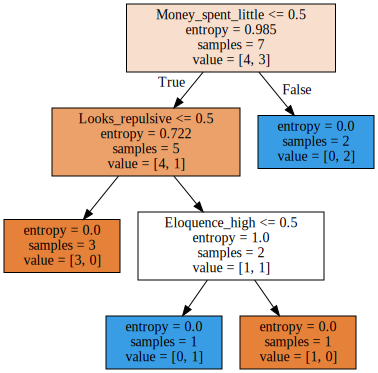

In [10]:
tree_str = export_graphviz(
    dt, feature_names=df_train.columns, out_file=None, filled=True)
graph = pydotplus.graph_from_dot_data(tree_str)
SVG(graph.create_svg())

### 计算熵和信息增益

接下来，我们换另外一个例子：假设有 9 个蓝色球和 11 个黄色球。如果球是蓝色，则让球的标签是 1，否则为 0。

In [11]:
balls = [1 for i in range(9)] + [0 for i in range(11)]  # 生成数据

<img src = 'https://doc.shiyanlou.com/courses/uid214893-20190505-1557034726255'>

接下来将球分成如下两组：

<img src = 'https://doc.shiyanlou.com/courses/uid214893-20190505-1557034743748'>

In [12]:
# 数据分组
# 8 蓝色 和 5 黄色
balls_left = [1 for i in range(8)] + [0 for i in range(5)]
# 1 蓝色 和 6 黄色
balls_right = [1 for i in range(1)] + [0 for i in range(6)]

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>请根据前面的实验内容实现香农熵计算函数 `entropy()`。

实现函数时，请结合下一题给出的测试示例，保证测试用例可以执行成功。

In [13]:
from math import log


def entropy(a_list):
    lst = list(a_list)
    size = len(lst) * 1.0
    entropy = 0
    set_elements = len(set(lst))
    if set_elements in [0, 1]:
        return 0
    for i in set(lst):
        occ = lst.count(i)
        entropy -= occ/size * log(occ/size, 2)
    return entropy

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>列表 ball_left 给出状态的熵是多少？

In [14]:
entropy(balls_left)  # 8 蓝色 и 5 黄色

0.961236604722876

<font color='green'><i class="fa fa-check-circle-o" aria-hidden="true"> 期望结果：</i></font>0.961

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>如果有一个 6 面立方体等概率骰子，其熵是多少？

In [15]:
entropy([1, 2, 3, 4, 5, 6])  # 6 面等概率骰子熵

2.584962500721156

<font color='green'><i class="fa fa-check-circle-o" aria-hidden="true"> 期望结果：</i></font>2.585

接下来，请实现信息增益的计算函数 `information_gain(root, left, right)`。

In [16]:
# 信息增益计算
def information_gain(root, left, right):
    ''' root - 初始数据, left and right - 分组数据'''
    return entropy(root) - 1.0 * len(left) / len(root) * entropy(left) \
                         - 1.0 * len(right) / len(root) * entropy(right)

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>将初始数据集拆分为 balls_left 和 balls_right 后的信息增益是多少？

In [17]:
information_gain(balls, balls_left, balls_right)

0.16088518841412436

<font color='green'><i class="fa fa-check-circle-o" aria-hidden="true"> 期望结果：</i></font>0.161

接下来，我们尝试实现基于信息增益划分函数 `best_feature_to_split`。

In [18]:
def best_feature_to_split(X, y):
    '''信息增益用于特征分割'''
    out = []
    for i in X.columns:
        out.append(information_gain(y, y[X[i] == 0], y[X[i] == 1]))
    return out

然后，通过递归调用 `best_feature_to_split` 实现一个简单的树构建策略，并输出每一步的熵变化。

In [19]:
def btree(X, y):
    clf = best_feature_to_split(X, y)
    param = clf.index(max(clf))
    ly = y[X.iloc[:, param] == 0]
    ry = y[X.iloc[:, param] == 1]
    print('Column_' + str(param) + ' N/Y?')
    print('Entropy: ', entropy(ly), entropy(ry))
    print('N count:', ly.count(), '/', 'Y count:', ry.count())
    if entropy(ly) != 0:
        left = X[X.iloc[:, param] == 0]
        btree(left, ly)
    if entropy(ry) != 0:
        right = X[X.iloc[:, param] == 1]
        btree(right, ry)

In [20]:
best_feature_to_split(df_train, y)

[0.46956521111470706,
 0.46956521111470706,
 0.12808527889139454,
 0.12808527889139454,
 0.2916919971380598,
 0.02024420715375619,
 0.005977711423774124,
 0.005977711423774124]

In [21]:
btree(df_train, y)

Column_0 N/Y?
Entropy:  0.7219280948873623 0
N count: 5 / Y count: 2
Column_2 N/Y?
Entropy:  1.0 0
N count: 2 / Y count: 3
Column_4 N/Y?
Entropy:  0 0
N count: 1 / Y count: 1


### 构建 Adult 数据集决策树

[<i class="fa fa-external-link-square" aria-hidden="true"> UCI Adult</i>](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) 人口收入普查数据集前面已经使用过了，其具有以下一些特征：

- Age – 连续数值特征
- Workclass –  连续数值特征
- fnlwgt – 连续数值特征
- Education –  类别特征
- Education_Num – 连续数值特征
- Martial_Status –  类别特征
- Occupation –  类别特征
- Relationship – 类别特征
- Race – 类别特征
- Sex – 类别特征
- Capital_Gain – 连续数值特征
- Capital_Loss – 连续数值特征
- Hours_per_week – 连续数值特征
- Country – 类别特征

- Target – 收入水平，二元分类目标值

接下来，我们加载并读取该数据集：

In [22]:
data_train = pd.read_csv(
    'https://labfile.oss.aliyuncs.com/courses/1283/adult_train.csv', sep=';')

In [23]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [ ]:
data_test = pd.read_csv(
    'https://labfile.oss.aliyuncs.com/courses/1283/adult_test.csv', sep=';')

In [ ]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


然后，对数据集进行一些必要的清洗。同时，将目标值转换为 0，1 二元数值。

In [ ]:
# 移除测试集中的错误数据
data_test = data_test[(data_test['Target'] == ' >50K.')
                      | (data_test['Target'] == ' <=50K.')]

# 将目标编码为 0 和 1
data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1

输出测试数据概览表，查看特征和目标值的各项统计指标。

In [ ]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


接下来，查看训练数据集目标分布计数，同时绘制各项特征的关联分布图像。

In [ ]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

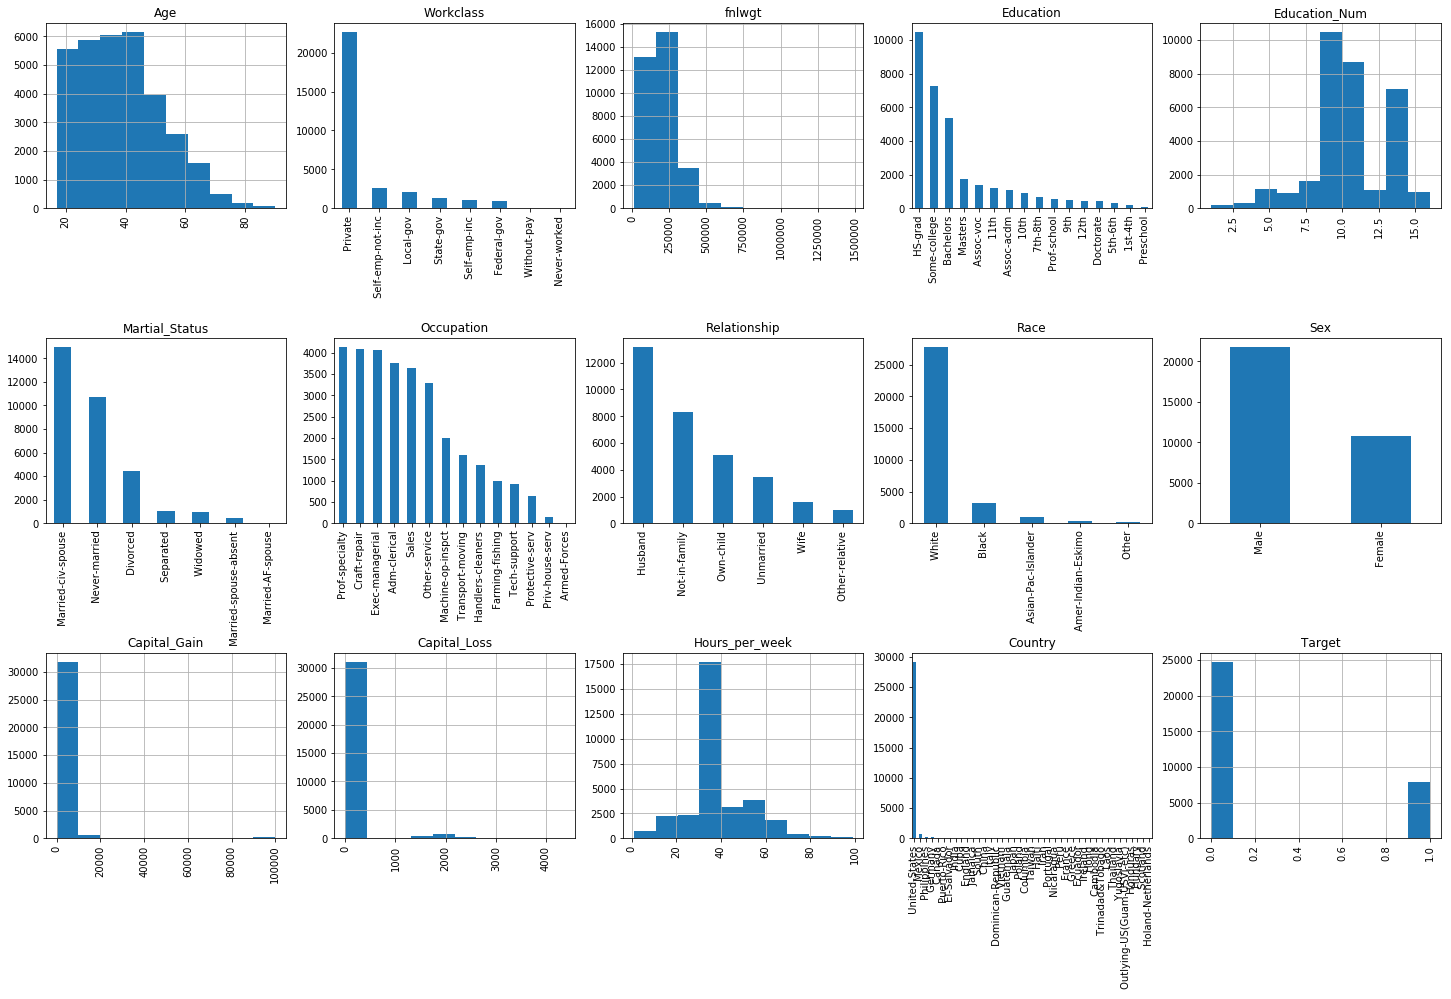

In [ ]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

进一步分析之前，需要检查数据的类型。

In [ ]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [ ]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target              int64
dtype: object

可以看的测试数据中，年龄 Age 是 object 类型，我们需要修复其为整数类型。

In [ ]:
data_test['Age'] = data_test['Age'].astype(int)

与此同时，我们将测试数据中浮点类型特征全部处理成整数类型，以便与训练数据对应。

In [ ]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

这里还需要继续对数据预处理，首先区分数据集中的类别和连续特征。

In [ ]:
# 从数据集中选择类别和连续特征变量
categorical_columns = [c for c in data_train.columns
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


然后，对连续特征使用中位数对缺失数据进行填充，而类别特征则使用众数进行填充。

In [ ]:
# 填充缺失数据
for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode(), inplace=True)
    data_test[c].fillna(data_train[c].mode(), inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

接下来，我们需要对类别特征进行独热编码，以保证数据集特征全部为数值类型方便后续传入模型。

In [ ]:
data_train = pd.concat([data_train[numerical_columns],
                        pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
                       pd.get_dummies(data_test[categorical_columns])], axis=1)

In [ ]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [ ]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

独热编码之后发现测试数据中没有 Holland，为了与训练数据对应，这里需要创建零值特征进行补齐。

In [ ]:
data_test['Country_ Holand-Netherlands'] = 0

In [ ]:
set(data_train.columns) - set(data_test.columns)

set()

In [ ]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

### 建立默认参数决策树模型

接下来，使用训练数据创建一个决策树分类器。挑战规定 `max_depth=3`，`random_state=17`。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>按挑战要求构建决策树，并输出其在测试集上的准确度？

In [ ]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [ ]:
tree_predictions = tree.predict(X_test)

In [ ]:
accuracy_score(y_test, tree_predictions)

0.8447884036607088

<font color='green'><i class="fa fa-check-circle-o" aria-hidden="true"> 期望结果：</i></font>0.845

### 对决策树模型进行调参

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>使用 GridSearchCV 网格搜索对决策树进行调参并返回最佳参数。

挑战规定，决策树参数 `random_state = 17`，GridSearchCV 参数 `cv=5`，并对 `max_depth` 参数在 $[8, 10]$ 范围进行网格搜索。

In [ ]:
tree_params = {'max_depth': range(8, 11)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17),
                                 tree_params, cv=5)

locally_best_tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(8, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [ ]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8562697705844415


<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>构建上面最佳参数决策树，并输出其在测试集上的准确度？

In [ ]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

0.8471838339168356

<font color='green'><i class="fa fa-check-circle-o" aria-hidden="true"> 期望结果：</i></font>0.847

### 建立随机森林分类模型

和上面建立决策树相似，可以利用 scikit-learn 提供的随机森林算法建立相应的分类预测模型。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>构建 RandomForestClassifier 随机森林分类器。挑战规定参数 `n_estimators=100` 且 `random_state=17`，其余默认。

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

输出在测试集上的分类预测准确度。

In [ ]:
forest_predictions = rf.predict(X_test) 

In [ ]:
accuracy_score(y_test,forest_predictions)

<font color='green'><i class="fa fa-check-circle-o" aria-hidden="true"> 期望结果：</i></font>0.858

---

<div style="background-color: #e6e6e6; margin-bottom: 10px; padding: 1%; border: 1px solid #ccc; border-radius: 6px;text-align: center;"><a href="https://nbviewer.jupyter.org/github/shiyanlou/mlcourse-answers/tree/master/" title="挑战参考答案"><i class="fa fa-file-code-o" aria-hidden="true"> 查看挑战参考答案</i></a></div>